In [1]:
# Import the libraries we need to use in this lab
from __future__ import print_function
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVC
import ssl
import certifi
import urllib.request

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/creditcard.csv"
ssl_context = ssl.create_default_context(cafile=certifi.where())
with urllib.request.urlopen(path, context=ssl_context) as response:
    data = pd.read_csv(response)
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


# Data Analysis and Pre-processing

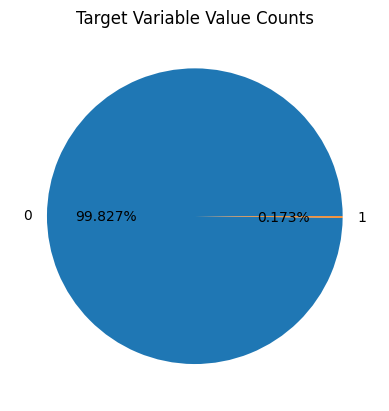

In [15]:
# get the set of distinct classes
labels = data.Class.unique()

# get the count of each class
sizes = data.Class.value_counts().values

# plot the class value counts
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title('Target Variable Value Counts')
plt.show()

As shown above, the Class variable has two values: 0 (the credit card transaction is legitimate) and 1 (the credit card transaction is fraudulent). Thus, you need to model a binary classification problem. Moreover, the dataset is highly unbalanced, the target variable classes are not represented equally. This case requires special attention when training or when evaluating the quality of a model. One way of handing this case at train time is to bias the model to pay more attention to the samples in the minority class. The models under the current study will be configured to take into account the class weights of the samples at train/fit time.

<Axes: >

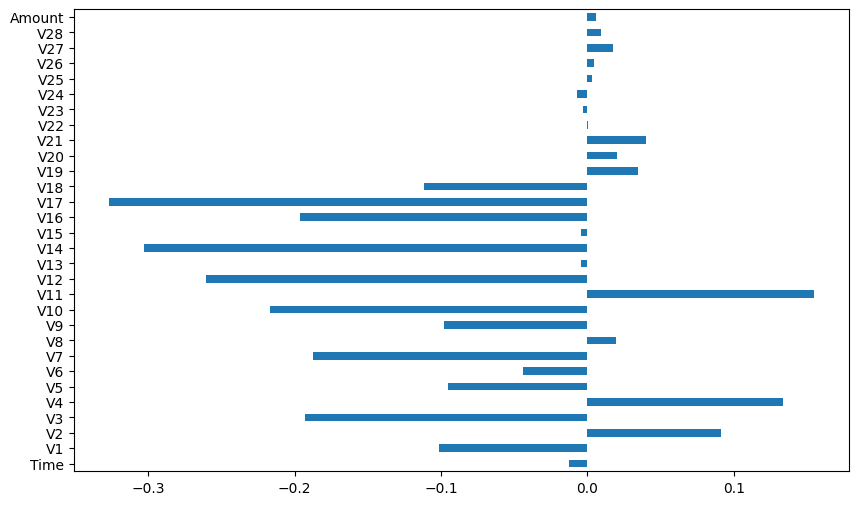

In [16]:
# We can visualize the effect of the different features
correlation_values = data.corr()['Class'].drop('Class')
correlation_values.plot(kind='barh', figsize=(10, 6))

Prepare the data for training. Apply standard scaling to the input features and normalize them using $L_1$ norm for the training models to converge quickly. As seen in the data snapshot, there is a parameter called `Time` which we will not be considering for modeling. Hence, features 2 to 30 will be used as input features and feature 31, i.e. Class will be used as the target variable.


In [17]:
# standardize features by removing the mean and scaling to unit variance
data.iloc[:, 1:30] = StandardScaler().fit_transform(data.iloc[:, 1:30])
data_matrix = data.values

# X: feature matrix (for this analysis, we exclude the Time variable from the dataset)
X = data_matrix[:, 1:30]

# y: labels vector
y = data_matrix[:, 30]

# data normalization
X = normalize(X, norm="l1")

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modeling (Decision tree classifier)

In [8]:
# Compute the sample weights to be used as input to the train 
# routine so that it takes into account the class imbalance present in this dataset.
w_train = compute_sample_weight('balanced', y_train)

dt = DecisionTreeClassifier(max_depth=4, random_state=35)

dt.fit(X_train, y_train, sample_weight=w_train)

,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,35
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


# Modeling (Support Vector Machine)

In [9]:
# for reproducible output across multiple function calls, set random_state to a given integer value
svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)

svm.fit(X_train, y_train)

,penalty,'l2'
,loss,'hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,False
,intercept_scaling,1
,class_weight,'balanced'
,verbose,0
,random_state,31


# Evaluation (Decision tree classifier)

In [11]:
y_pred_dt = dt.predict_proba(X_test)[:,1]
roc_auc_dt = roc_auc_score(y_test, y_pred_dt)
print('Decision Tree ROC-AUC score : {0:.3f}'.format(roc_auc_dt))

Decision Tree ROC-AUC score : 0.939


# Evaluation (Support Vector Machine)

In [13]:
y_pred_svm = svm.decision_function(X_test)
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)
print("SVM ROC-AUC score: {0:.3f}".format(roc_auc_svm))

SVM ROC-AUC score: 0.986


# Questions

Q1. Currently, we have used all 30 features of the dataset for training the models. Use the corr() function to find the top 6 features of the dataset to train the models on.

In [14]:
correlation_values = abs(data.corr()['Class']).drop('Class')
correlation_values = correlation_values.sort_values(ascending=False)[:6]
correlation_values

V17    0.326481
V14    0.302544
V12    0.260593
V10    0.216883
V16    0.196539
V3     0.192961
Name: Class, dtype: float64

Q2. Using only these 6 features, modify the input variable for training.

In [22]:
data.iloc[:, 1:30] = StandardScaler().fit_transform(data.iloc[:, 1:30])
data_matrix = data.values

X = data_matrix[:,[3,10,12,14,16,17]]
y = data_matrix[:, 30]

X = normalize(X, norm="l1")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Q3. Execute the Decision Tree model for this modified input variable. How does the value of ROC-AUC metric change?

In [ ]:

w_train = compute_sample_weight('balanced', y_train)

dt.fit(X_train, y_train, sample_weight=w_train)
y_pred_dt = dt.predict_proba(X_test)[:,1]
roc_auc_dt = roc_auc_score(y_test, y_pred_dt)
print('Decision Tree ROC-AUC score : {0:.3f}'.format(roc_auc_dt))

Decision Tree ROC-AUC score : 0.952


Q4. Execute the SVM model for this modified input variable. How does the value of ROC-AUC metric change?

In [24]:
svm.fit(X_train, y_train)
y_pred_svm = svm.decision_function(X_test)
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)
print("SVM ROC-AUC score: {0:.3f}".format(roc_auc_svm))

SVM ROC-AUC score: 0.937


Q5. What are the inferences you can draw about Decision Trees and SVMs with what you have learnt in this lab?

- With a larger set of features, SVM performed relatively better in comparison to the Decision Trees.
- Decision Trees benefited from feature selection and performed better.
- SVMs may require higher feature dimensionality to create an efficient decision hyperplane.